In [208]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'

In [98]:
import geopandas as gpd
plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")

In [151]:
bland = plz.set_index("plz")['bundesland']
#bland = bland[~bland.index.duplicated(keep='first')]

In [96]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [154]:
df = df[df.date > '2021-10-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [155]:
df_filtered

,sending_pc,date,all,omi,days,sending_area,sending_pc_ID,bundesland
0,01067,2021-10-02,0,0,-96,0,0,Sachsen
1,01067,2021-10-03,0,0,-95,0,0,Sachsen
2,01067,2021-10-04,0,0,-94,0,0,Sachsen
3,01067,2021-10-05,11,0,-93,0,0,Sachsen
4,01067,2021-10-06,0,0,-92,0,0,Sachsen
...,...,...,...,...,...,...,...,...
23125,90530,2021-12-26,0,0,-11,9,87,Bayern
23126,90530,2021-12-27,4,1,-10,9,87,Bayern
23127,90530,2021-12-28,3,0,-9,9,87,Bayern
23128,90530,2021-12-29,0,0,-8,9,87,Bayern


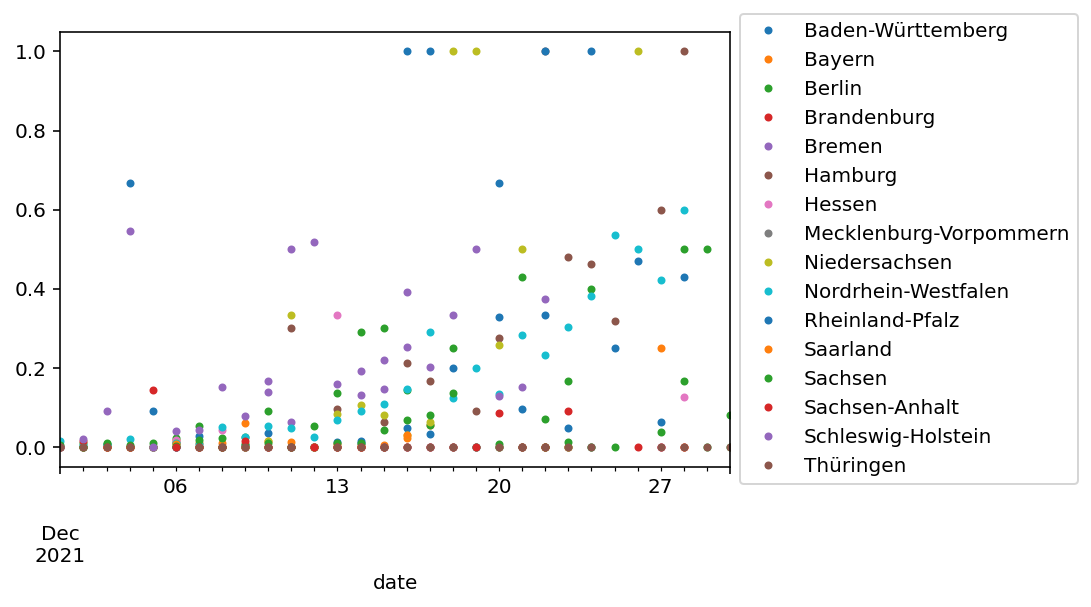

In [196]:
foo = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
foo = foo.sum(level=[0,2]).loc[:,"2021-12-01":,:]
foo['prop'] = foo.omi / foo['all']
for r in foo.index.levels[0]:
    foo.loc[r]['prop'].plot(ls="", marker=".", label=r)
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')

In [110]:
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {k: LocScaleReparam(0) for k in ["mu_a", "a"]}

@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sample_day, total_counts,omi_counts=None):
    mu_a_mu = numpyro.sample("mu_a_mu", dist.Normal(0, 3.0))
    mu_a_sigma = numpyro.sample("mu_a_sigma", dist.HalfNormal(2.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(2.0))
    b = numpyro.sample("b", dist.Normal(0.2, 0.2))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_area))

    sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

    with numpyro.plate("plate_i", n_areas):
        mu_a = numpyro.sample("mu_a", dist.Normal(mu_a_mu, mu_a_sigma))

    with numpyro.plate("plate_j", n_labs):
        a = numpyro.sample("a", dist.Normal(mu_a[sending_pc_to_area], sigma_a))

    logit_est = a[sending_pc] + b * sample_day


    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [157]:
nuts_kernel = NUTS(model3)

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sending_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 7000/7000 [17:04<00:00,  6.83it/s, 1023 steps of size 7.98e-04. acc. prob=0.88]


In [158]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
    a_decentered[0]     -0.70      0.41     -0.69     -1.38     -0.04    110.18      1.00
    a_decentered[1]      0.11      0.41      0.11     -0.57      0.76    109.59      1.02
    a_decentered[2]      0.57      0.59      0.58     -0.40      1.51    115.97      1.01
    a_decentered[3]     -1.42      0.67     -1.39     -2.50     -0.27    165.25      1.00
    a_decentered[4]     -0.54      0.56     -0.51     -1.47      0.34    160.66      1.01
    a_decentered[5]     -0.30      0.89     -0.26     -1.68      1.20    224.37      1.00
    a_decentered[6]      0.90      0.45      0.90      0.18      1.68     80.52      1.03
    a_decentered[7]     -0.31      0.87     -0.27     -1.75      1.03    199.94      1.00
    a_decentered[8]      1.23      0.35      1.23      0.62      1.80     59.25      1.06
    a_decentered[9]     -0.85      0.77     -0.87     -2.10      0.45    151.87      1.02
   a_dece

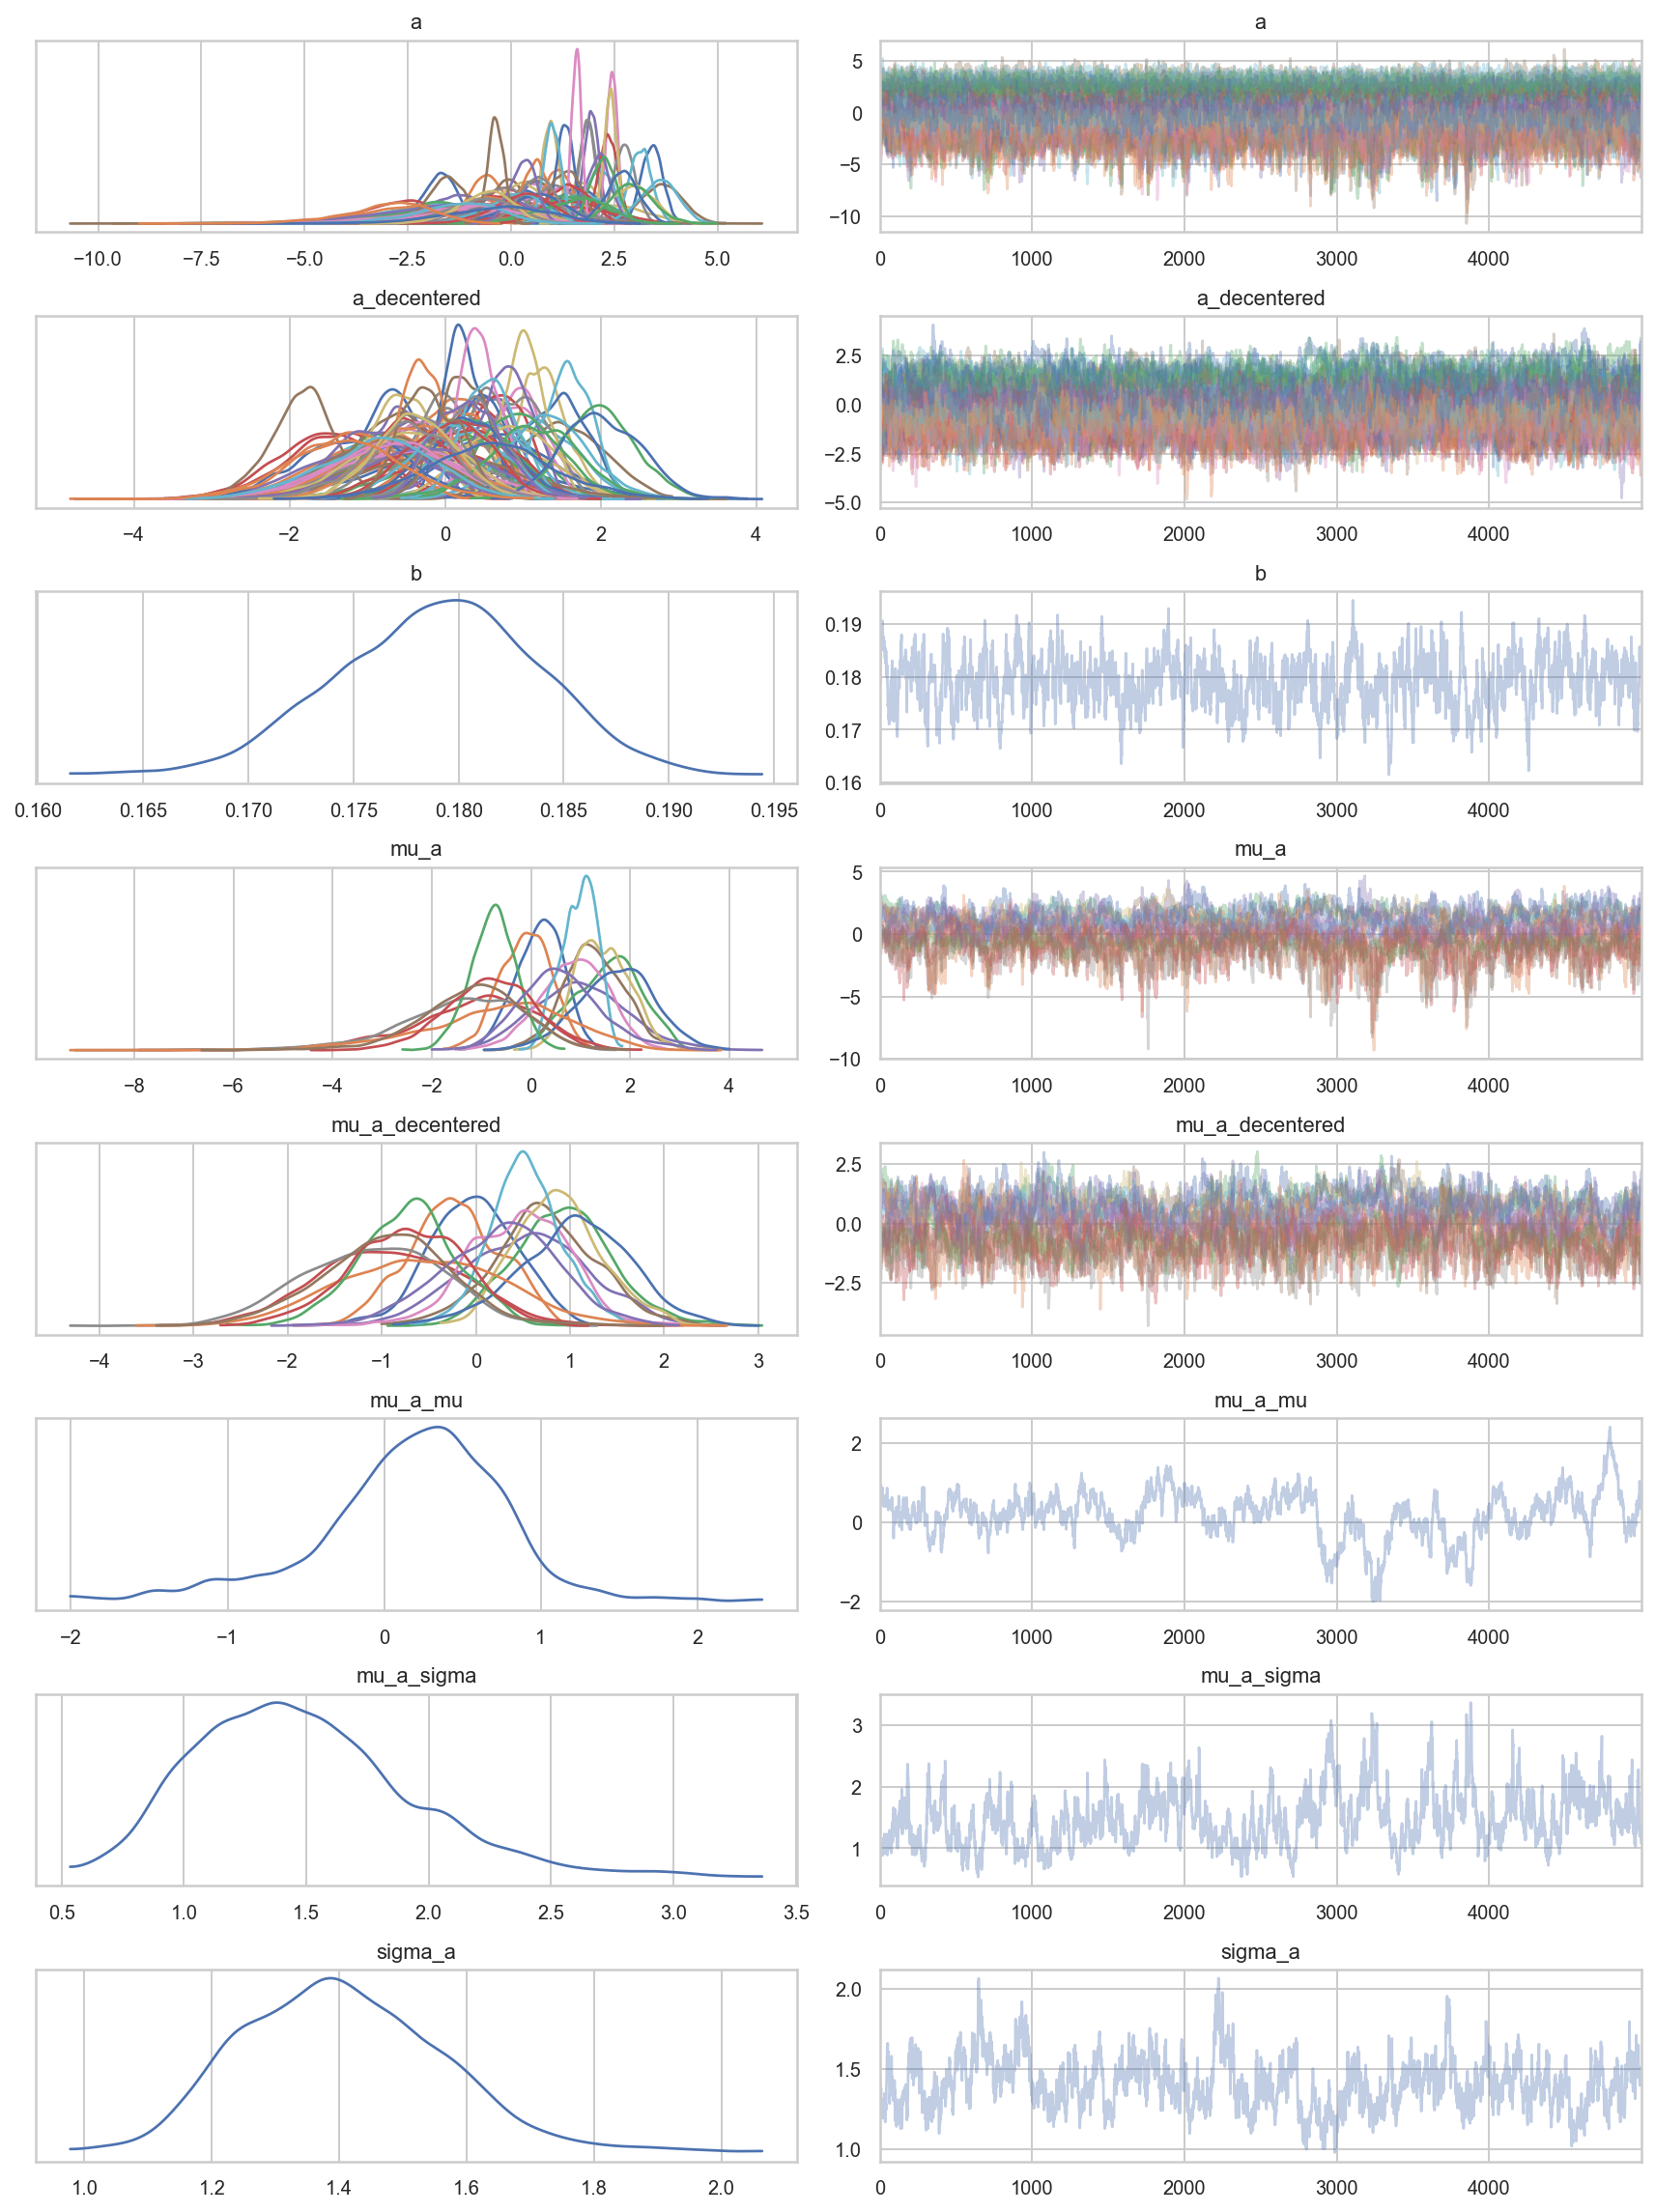

In [159]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [160]:
s = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(s['b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(s['b']['5.0%'])-1:.1%}, {np.exp(s['b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+s['b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+s['b']['95.0%']):.2},{np.log(2)/np.log(1+s['b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    19.6% mit 90%-Konfidenzintervall [18.7%, 20.5%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    4.2 Tage mit 90%-Konfidenzintervall [4.0,4.4]
    


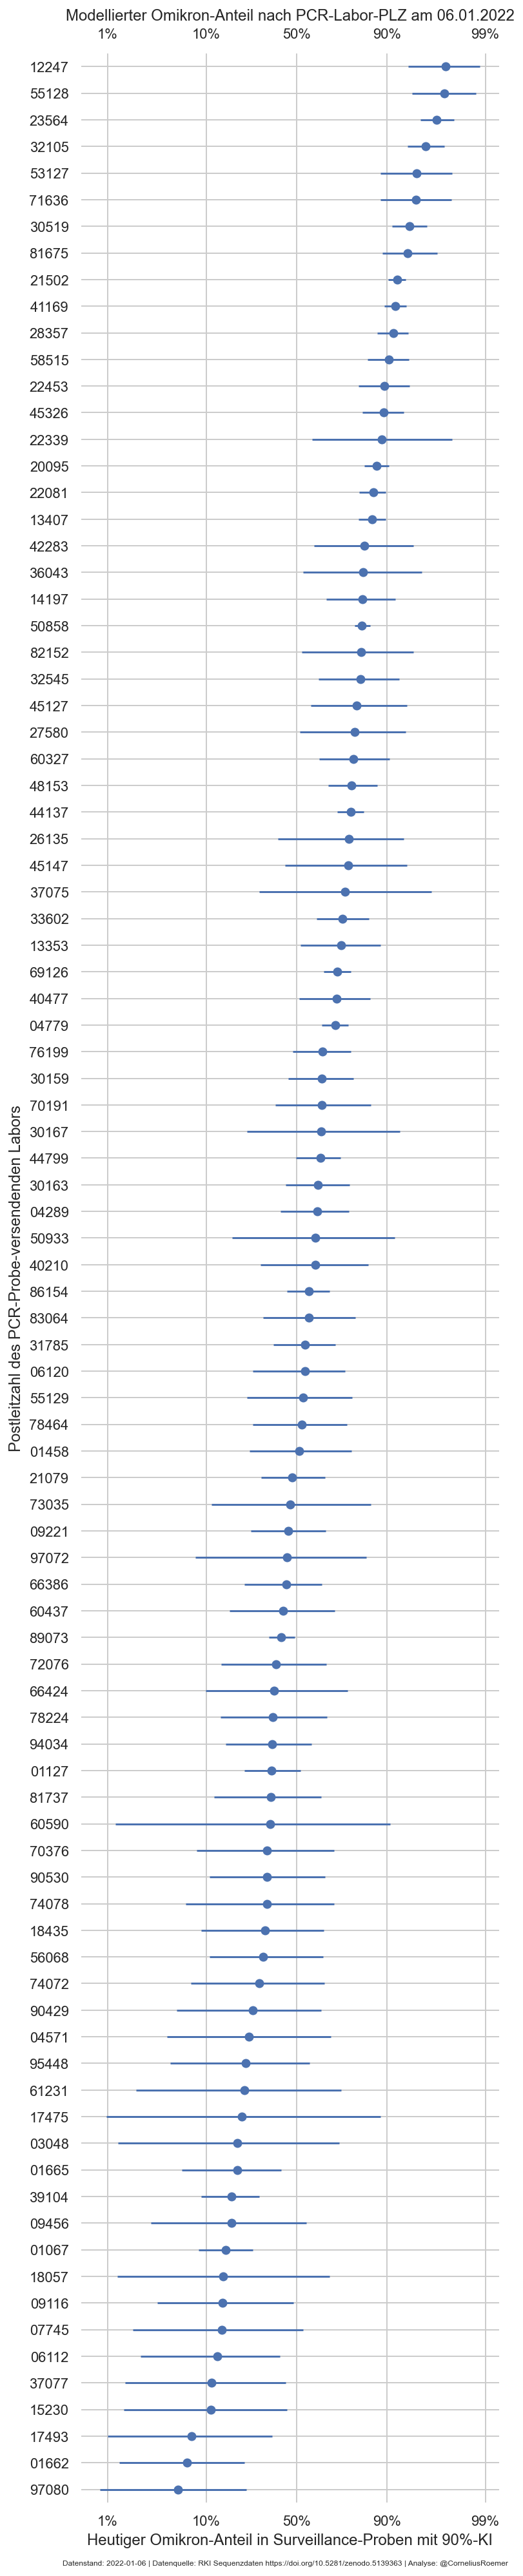

In [161]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(s['a'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

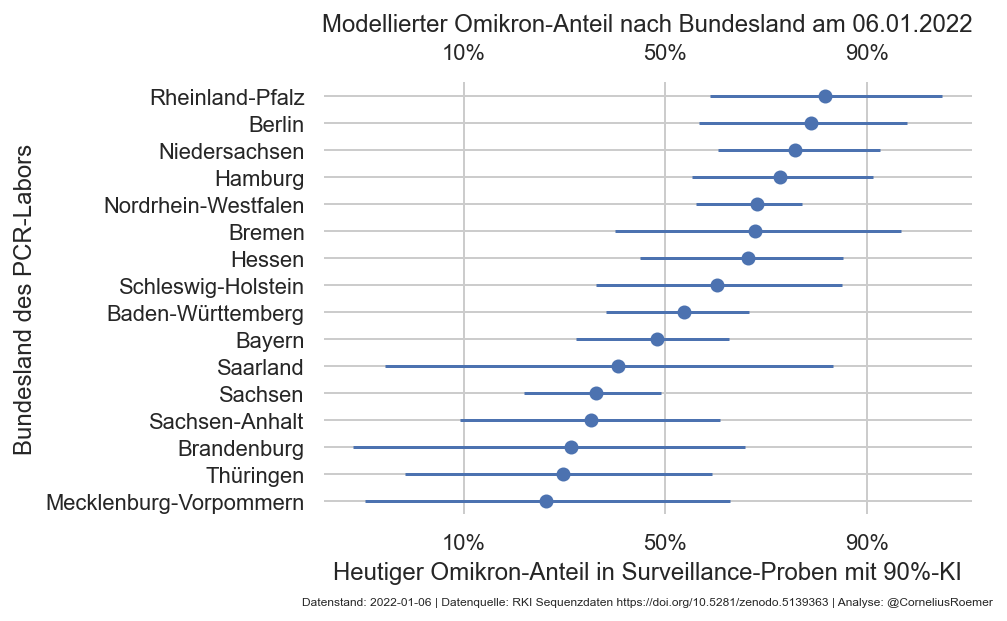

In [163]:
pdf = pd.DataFrame(s['mu_a'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [164]:
plz_bl = plz.dissolve(by="bundesland")

(5.407540630000054, 15.500583370000044, 46.880682800000066, 55.44811200000006)

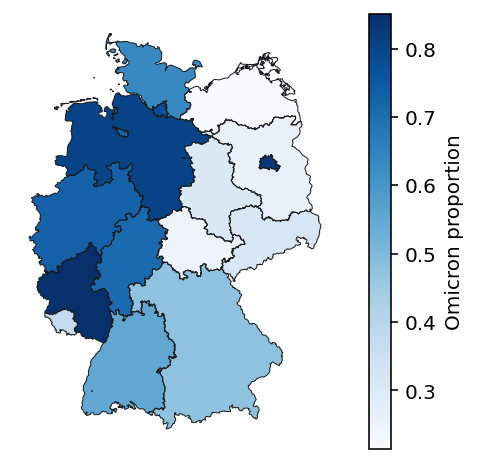

In [217]:
#sns.set_style("white")
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf['prop'] = expit(pdf['median'])
plz_bl.merge(pdf, left_index=True, right_index=True).plot("prop", lw=1, cmap="Blues", 
                                                          legend=True,
                                                         legend_kwds={'label': "Omicron proportion"})
plz_bl.simplify(1e-2, preserve_topology=False).boundary.plot(color='k',lw=0.5, ax=plt.gca())
plt.axis('off')


/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


<AxesSubplot:xlabel='bundesland,week'>

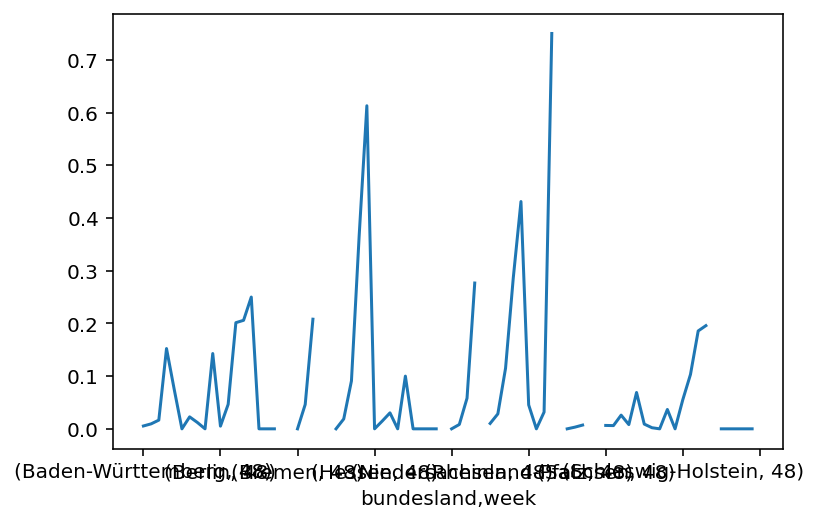

In [227]:
bar = foo.reset_index()
bar['week'] = bar.date.dt.week
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

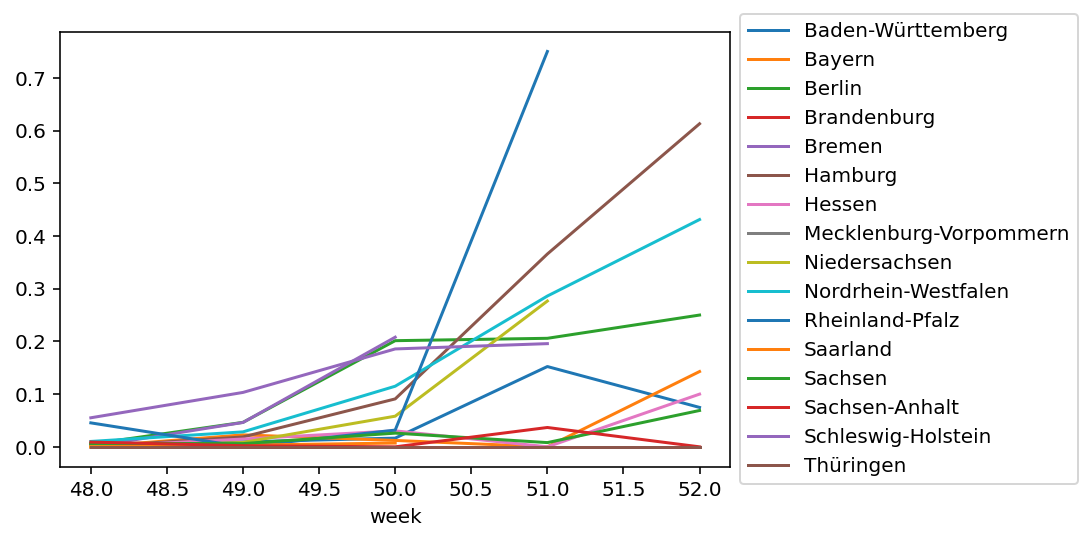

In [229]:
for r in bar.index.levels[0]:
    bar.loc[r]['prop'].plot( label=r)
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [231]:
bar.loc[:,51:52,:]

all  omi  days  sending_area  sending_pc_ID  \
bundesland             week                                                
Baden-Württemberg      51    302   46 -1176           588           6293   
                       52    214   16  -408           336           3596   
Bayern                 51     16    0 -1078           658           6587   
                       52      7    1  -374           376           3764   
Berlin                 51     34    7  -392            28            462   
                       52     12    3  -136            16            264   
Brandenburg            51      0    0  -196             7            168   
                       52      0    0   -68             4             96   
Bremen                 51      0    0  -196            28            455   
                       52      0    0   -68            16            260   
Hamburg                51    164   60  -686            98           1337   
                       52     31   19  -238            56            764   
Hessen                 51      4    0  -392           147           1645   
                       52     10    1  -136            84            940   
Mecklenburg-Vorpommern 51     19    0  -686            49           1050   
                       52      0    0  -238            28            600   
Niedersachsen          51     47   13  -882           182           2324   
                       52      0    0  -306           104           1328   
Nordrhein-Westfalen    51    762  218 -1764           511           6363   
                       52    109   47  -612           292           3636   
Rheinland-Pfalz        51      4    3  -294           105           1260   
                       52      0    0  -102            60            720   
Saarland               51      0    0  -196            84            945   
                       52      0    0   -68            48            540   
Sachsen                51    373    3 -1274             0            518   
                       52    145   10  -442             0            296   
Sachsen-Anhalt         51    109    4  -294            21            448   
                       52     82    0  -102            12            256   
Schleswig-Holstein     51    189   37  -294            42            574   
                       52      0    0  -102            24            328   
Thüringen              51     23    0  -294           126           1372   
                       52     12    0  -102            72            784   

                                 prop  
bundesland             week            
Baden-Württemberg      51    0.152318  
                       52    0.074766  
Bayern                 51    0.000000  
                       52    0.142857  
Berlin                 51    0.205882  
                       52    0.250000  
Brandenburg            51         NaN  
                       52         NaN  
Bremen                 51         NaN  
                       52         NaN  
Hamburg                51    0.365854  
                       52    0.612903  
Hessen                 51    0.000000  
                       52    0.100000  
Mecklenburg-Vorpommern 51    0.000000  
                       52         NaN  
Niedersachsen          51    0.276596  
                       52         NaN  
Nordrhein-Westfalen    51    0.286089  
                       52    0.431193  
Rheinland-Pfalz        51    0.750000  
                       52         NaN  
Saarland               51         NaN  
                       52         NaN  
Sachsen                51    0.008043  
                       52    0.068966  
Sachsen-Anhalt         51    0.036697  
                       52    0.000000  
Schleswig-Holstein     51    0.195767  
                       52         NaN  
Thüringen              51    0.000000  
                       52    0.000000

In [271]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [272]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [285]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land

AnzahlFall
bundesland Refdatum              
1          2020-01-01           4
           2020-01-02           2
           2020-01-03           4
           2020-01-04           5
           2020-01-05           5
...                           ...
16         2022-01-01         405
           2022-01-02         374
           2022-01-03         871
           2022-01-04        1081
           2022-01-05         801

[11055 rows x 1 columns]

In [295]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

Text(0, 0.5, 'cases')

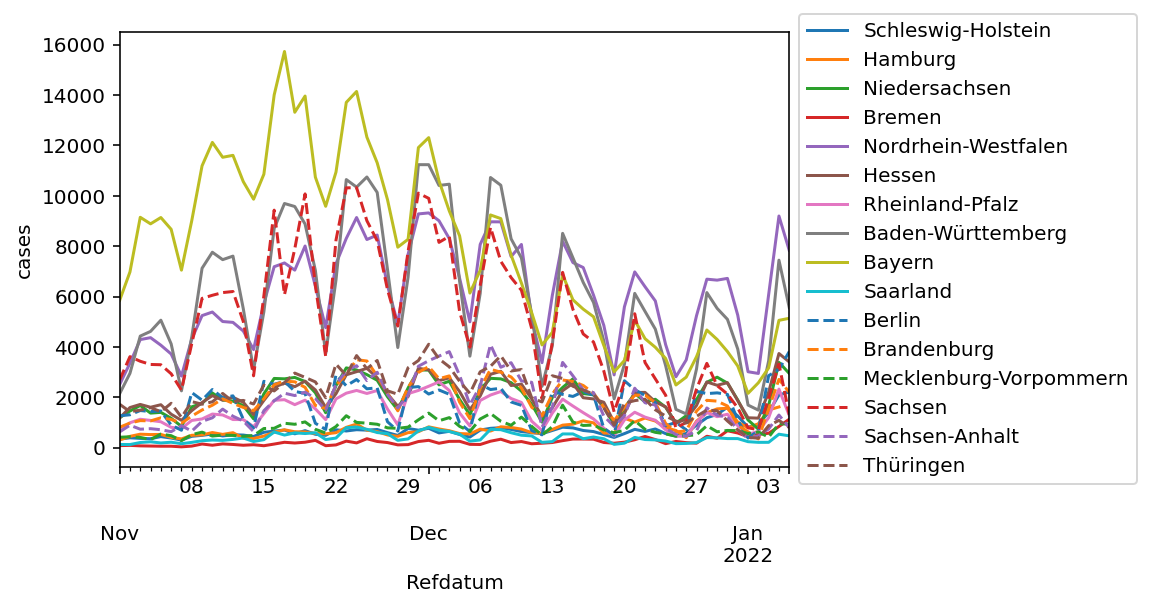

In [327]:
for r in cases_land.index.levels[0]:
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=b[r], ls="-" if r<11 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

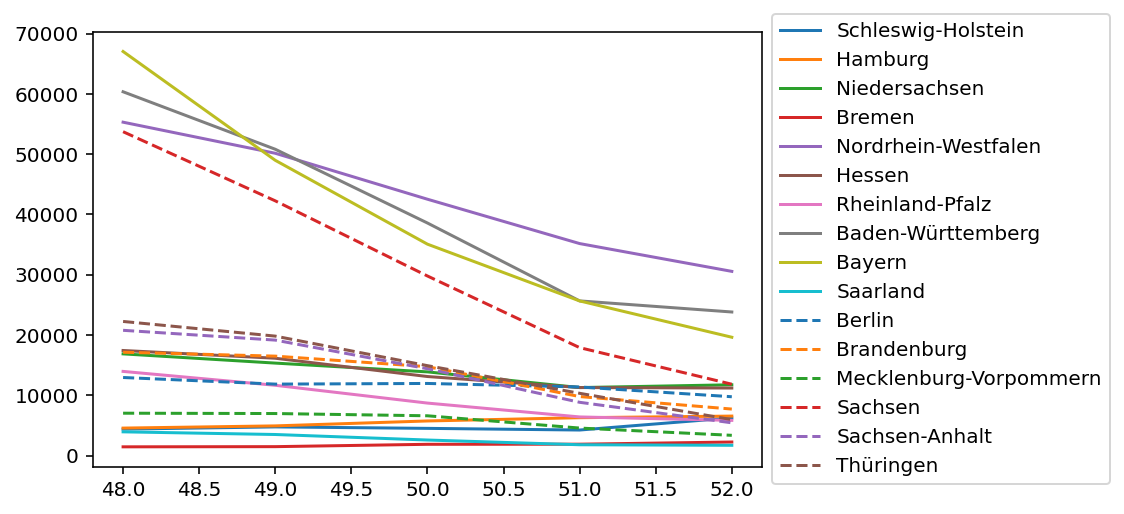

In [314]:
for r in cases_land.index.levels[0]:
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum.dt.isocalendar().week
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[b[r]], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=b[r], ls="-" if r < 11 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Omicron cases')

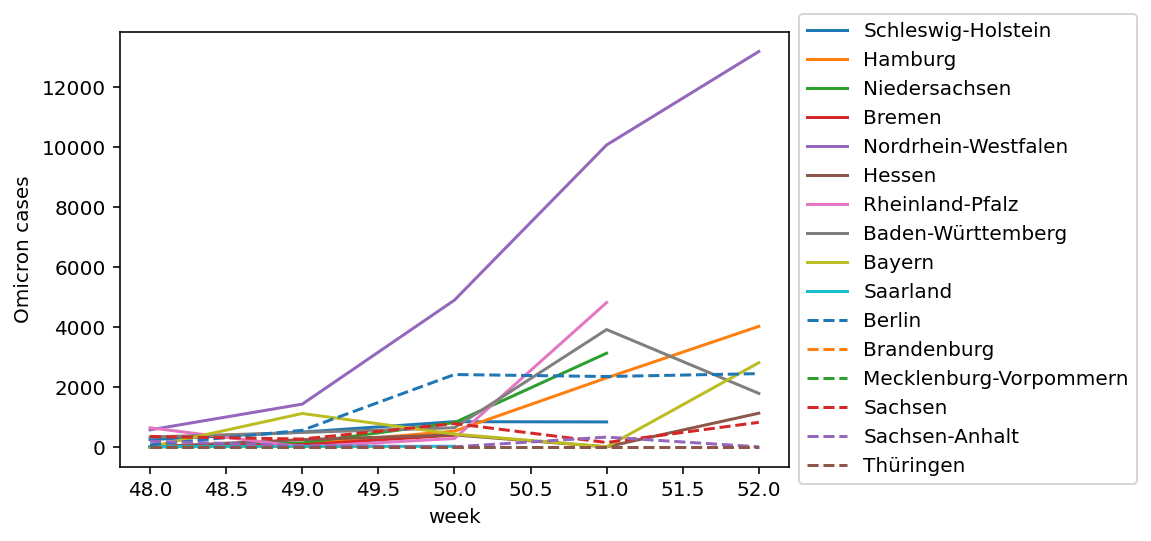

In [331]:
for r in cases_land.index.levels[0]:
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum.dt.isocalendar().week
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[b[r]], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=b[r], ls="-" if r < 11 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

In [328]:
bar

all  omi  days  sending_area  sending_pc_ID      prop
bundesland        week                                                       
Baden-Württemberg 48    556    3 -2040           420           4495  0.005396
                  49    954    9 -2352           588           6293  0.009434
                  50    666   11 -1764           588           6293  0.016517
                  51    302   46 -1176           588           6293  0.152318
                  52    214   16  -408           336           3596  0.074766
...                     ...  ...   ...           ...            ...       ...
Thüringen         48     24    0  -510            90            980  0.000000
                  49    143    0  -588           126           1372  0.000000
                  50    240    0  -441           126           1372  0.000000
                  51     23    0  -294           126           1372  0.000000
                  52     12    0  -102            72            784  0.000000

[80 rows x 6 columns]

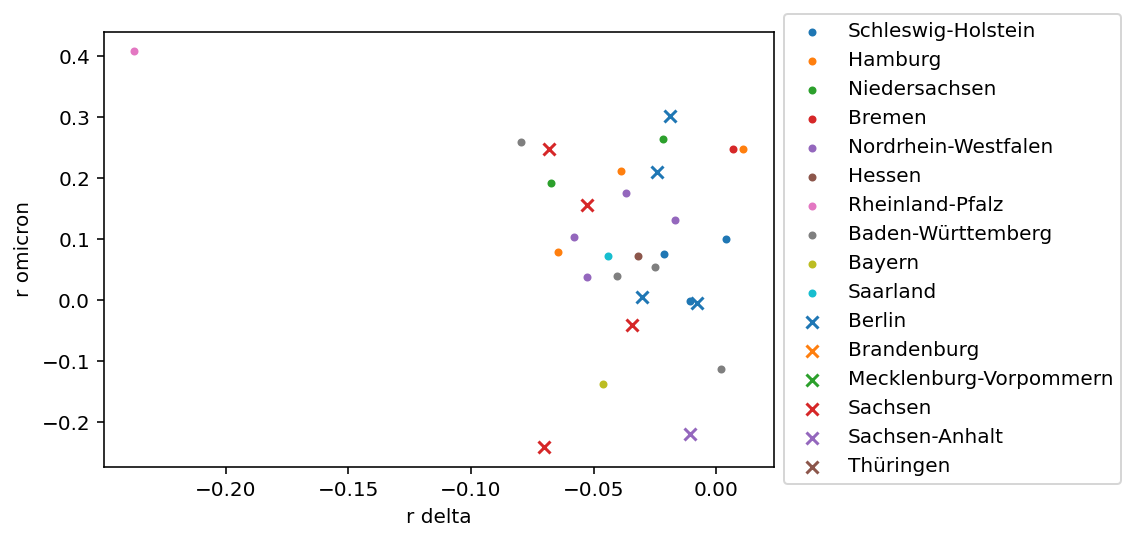

In [330]:
for r in cases_land.index.levels[0]:
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum.dt.isocalendar().week
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[b[r]], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=b[r], marker = "." if r <11 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [266]:
plz

,OBJECTID,plz,ags,ort,landkreis,bundesland,einwohner,note,SHAPE_Length,SHAPE_Area,geometry
0,1,52538,05370008,Gangelt,Kreis Heinsberg,Nordrhein-Westfalen,21390.0,"52538 Gangelt, Selfkant",0.683630,0.011630,"MULTIPOLYGON (((5.86632 51.05110, 5.86692 51.0..."
1,2,47559,05154040,Kranenburg,Kreis Kleve,Nordrhein-Westfalen,10220.0,47559 Kranenburg,0.627996,0.010011,"MULTIPOLYGON (((5.94504 51.82354, 5.94580 51.8..."
2,3,52525,05370016,Heinsberg,Kreis Heinsberg,Nordrhein-Westfalen,49737.0,"52525 Waldfeucht, Heinsberg",0.698334,0.015703,"MULTIPOLYGON (((5.96811 51.05556, 5.96951 51.0..."
3,4,52074,05334002,Aachen,Städteregion Aachen,Nordrhein-Westfalen,30606.0,52074 Aachen,0.465927,0.004158,"MULTIPOLYGON (((5.97486 50.79804, 5.97495 50.7..."
4,5,52531,05370028,Übach-Palenberg,Kreis Heinsberg,Nordrhein-Westfalen,24238.0,52531 Ãœbach-Palenberg,0.419177,0.003340,"MULTIPOLYGON (((6.01507 50.94788, 6.03854 50.9..."
...,...,...,...,...,...,...,...,...,...,...,...
8720,8721,02899,14626420,Ostritz,Landkreis Görlitz,Sachsen,4107.0,"02899 Ostritz, SchÃ¶nau-Berzdorf",0.613914,0.006535,"MULTIPOLYGON (((14.85296 51.06854, 14.85449 51..."
8721,8722,02929,14626480,Rothenburg/Oberlausitz,Landkreis Görlitz,Sachsen,5110.0,02929 Rothenburg/O.L.,0.766986,0.009365,"MULTIPOLYGON (((14.85491 51.32895, 14.85608 51..."
8722,8723,02827,14626110,Görlitz,Landkreis Görlitz,Sachsen,17068.0,02827 GÃ¶rlitz,0.533509,0.004755,"MULTIPOLYGON (((14.91168 51.14243, 14.91571 51..."
8723,8724,02828,14626110,Görlitz,Landkreis Görlitz,Sachsen,12016.0,02828 GÃ¶rlitz,0.350854,0.003248,"MULTIPOLYGON (((14.93413 51.16084, 14.93451 51..."
